In [19]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone

from glob import glob

In [ ]:
def load_iris_csv(file_path):
    """Loads a CSV file, assuming that the last column of the data is the target
    variable. The previous columns are interpreted as features and extracted.
    Returns a numpy array X with the features, a numpy array y with the corresponding
    target variables, a list of feature column names, and a list of class labels
    (all occurring target variables)."""

    data = pd.read_csv(file_path)

    feature_names = data.columns[:-1].tolist()

    class_names = data.iloc[:, -1].unique().tolist()

    X = data.iloc[:, :-1].values 

    y = data.iloc[:, -1].values
    # Encode string labels into integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    return X, y_encoded, feature_names, class_names

In [8]:
def kfold_crossval(classifier, X, y, k=10):
    """Evaluates a scikit-learn classifier using k-fold cross-validation. A
    scikit-learn classifier is guaranteed to have the fit(X, y) and predict(X)
    methods through its interface. The function receives a scikit-learn classifier,
    a design (feature) matrix X, a vector of class labels y, and the number of
    folds k, and returns the arithmetic mean of the validation accuracies and the
    training accuracies."""
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    val_accuracies = []
    train_accuracies = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Train the classifier on the training set
        classifier.fit(X_train, y_train)
        
        # Predict on the training set and calculate training accuracy
        y_train_pred = classifier.predict(X_train)
        train_accuracy = np.mean(y_train_pred == y_train)
        
        # Predict on the validation set and calculate validation accuracy
        y_val_pred = classifier.predict(X_val)
        val_accuracy = np.mean(y_val_pred == y_val)
        
        # Store the accuracies
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
    
    # Calculate the mean accuracies across all folds
    mean_train_accuracy = np.mean(train_accuracies)
    mean_val_accuracy = np.mean(val_accuracies)
    
    return mean_val_accuracy, mean_train_accuracy

In [13]:
def find_best_classifer_hyperparam(X, y, classifier, hyperparam_name, hyperparam_values):
    """Performs a search for the optimal hyperparameters based on 10-fold cross-validation.
    
    Args:
    - X: Feature matrix
    - y: Class labels
    - classifier: A scikit-learn classifier
    - hyperparam_name: The name of the hyperparameter to be optimized
    - hyperparam_values: List of hyperparameter values to be tested

    Returns:
    - best_classifier: The classifier trained with the best hyperparameter value
    - best_hyperparam: The value of the best hyperparameter
    """
    
    best_val_score = -float('inf')  # To maximize the score
    best_train_score = -float('inf')  # To track training score as well
    best_hyperparam = None
    best_classifier = None

    # Iterate through all the possible hyperparameter values
    for value in hyperparam_values:
        # Clone the classifier to ensure a fresh instance for each trial
        clf = clone(classifier)
        
        # Set the hyperparameter value for this trial
        setattr(clf, hyperparam_name, value)

        # Perform k-fold cross-validation and get the mean validation score
        mean_val_score, mean_train_score = kfold_crossval(clf, X, y, k=10)

        # Check if this hyperparameter value gives the best performance
        if mean_val_score > best_val_score:
            best_val_score = mean_val_score
            best_train_score = mean_train_score
            best_hyperparam = value
            best_classifier = clf

    # Retrain the best classifier with the best hyperparameter value on the full dataset
    setattr(best_classifier, hyperparam_name, best_hyperparam)
    best_classifier.fit(X, y)

    return best_classifier, best_hyperparam

In [10]:
# Task 1:
# TODO:
# Load 2-D dataset
# What about a test set?
# Find best k for kNN model
# Visualize test set predictions
# prediction surfaces -> see scikit-learn documentation and exercise sheet

Best k: 11
Test set accuracy: 0.77


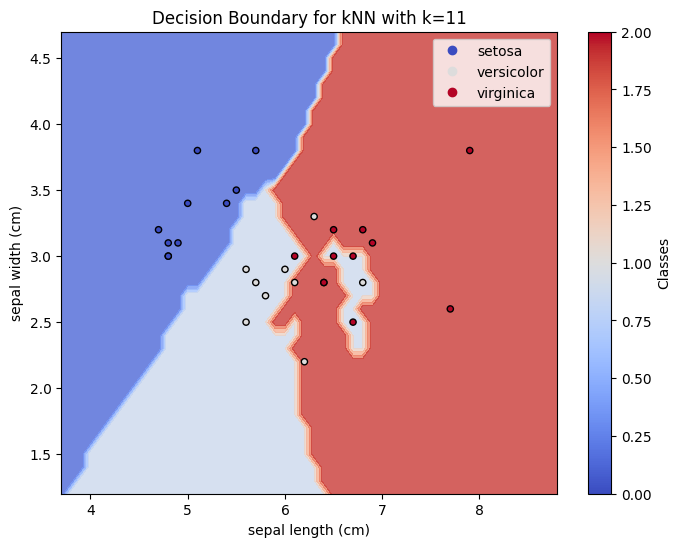

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

def load_iris_csv(file_path):
    """Loads the Iris dataset from a CSV file."""
    data = pd.read_csv(file_path)
    X = data.iloc[:, :-1].values  # Assuming last column is the target
    y = data.iloc[:, -1].values
    feature_names = data.columns[:-1].tolist()
    class_names = np.unique(y).tolist()
    return X, y, feature_names, class_names

def kfold_crossval(model, X, y, k=10):
    """Performs k-fold cross-validation and returns the mean accuracy."""
    kf = KFold(n_splits=k)
    accuracies = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train)
        accuracies.append(model.score(X_val, y_val))
    
    return np.mean(accuracies), accuracies

def find_best_k(X, y, k_values):
    """Finds the best value of k for kNN classifier using k-fold cross-validation."""
    best_k = None
    best_val_accuracy = -float('inf')
    best_knn = None
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        mean_val_accuracy, _ = kfold_crossval(knn, X, y, k=10)
        
        if mean_val_accuracy > best_val_accuracy:
            best_val_accuracy = mean_val_accuracy
            best_k = k
            best_knn = knn
            
    return best_knn, best_k

def plot_decision_boundary(clf, X, y, ax=None, cmap='coolwarm'):
    """Plots decision boundary of a classifier."""
    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array([class_names.index(label) for label in Z])

    Z = Z.reshape(xx.shape).astype(int)

    ax.contourf(xx, yy, Z, cmap=cmap, alpha=0.8)


    scatter = ax.scatter(X[:, 0], X[:, 1], c=np.array([class_names.index(label) for label in y]), cmap=cmap, edgecolors='k', s=20)

    return scatter

if __name__ == "__main__":
    # Load the Iris dataset
    X, y, feature_names, class_names = load_iris_csv('./iris_2D.csv') 

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Find the best k using cross-validation
    k_values = range(1, 21)  
    best_knn, best_k = find_best_k(X_train, y_train, k_values)
    
    print(f"Best k: {best_k}")

    # Evaluate the best classifier on the test set
    best_knn.fit(X_train, y_train)
    test_accuracy = best_knn.score(X_test, y_test)
    print(f"Test set accuracy: {test_accuracy:.2f}")
    
    # Visualize decision boundary for the best kNN classifier
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = plot_decision_boundary(best_knn, X_test, y_test, ax=ax)
    ax.set_title(f"Decision Boundary for kNN with k={best_k}")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.colorbar(scatter, ax=ax, label='Classes')
    plt.show()


In [ ]:
# Task 2:
# TODO:
# Load Datasets
# For each dataset
# what about a test set?
# Finds best k for kNN model
# report best accuracy
# For each dataset
# Try the same, but scale the data before

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Helper function to find the best k and evaluate accuracy
def evaluate_knn_with_scaling(file_path, scale=False):
    """Evaluate kNN on the dataset with and without scaling."""
    # Load the dataset
    X, y, feature_names, class_names = load_iris_csv(file_path)
    
    # Encode class labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    # Scale the data if required
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    # Hyperparameter search
    classifier = KNeighborsClassifier()
    hyperparam_name = "n_neighbors"
    hyperparam_values = range(1, 16)
    best_model, best_k = find_best_classifer_hyperparam(X_train, y_train, classifier, hyperparam_name, hyperparam_values)
    
    # Evaluate on the test set
    test_accuracy = best_model.score(X_test, y_test)
    
    return best_k, test_accuracy

# Datasets to evaluate
datasets = {
    "./iris_original.csv": "Original Features",
    "./iris_randfeatures.csv": "Randomized Features",
    "./iris_scaledfeatures.csv": "Pre-Scaled Features",
}

# Results dictionary
results = {"Dataset": [], "Best k (Unscaled)": [], "Test Accuracy (Unscaled)": [], "Best k (Scaled)": [], "Test Accuracy (Scaled)": []}

# Evaluate each dataset
for file_path, description in datasets.items():
    # Without scaling
    best_k_unscaled, test_acc_unscaled = evaluate_knn_with_scaling(file_path, scale=False)
    # With scaling
    best_k_scaled, test_acc_scaled = evaluate_knn_with_scaling(file_path, scale=True)
    
    # Store results
    results["Dataset"].append(description)
    results["Best k (Unscaled)"].append(best_k_unscaled)
    results["Test Accuracy (Unscaled)"].append(test_acc_unscaled)
    results["Best k (Scaled)"].append(best_k_scaled)
    results["Test Accuracy (Scaled)"].append(test_acc_scaled)

# Print results
print("Results Summary:")
results_df = pd.DataFrame(results)
print(results_df)


Results Summary:
               Dataset  Best k (Unscaled)  Test Accuracy (Unscaled)  \
0    Original Features                  3                  1.000000   
1  Randomized Features                  5                  0.833333   
2  Pre-Scaled Features                  6                  0.766667   

   Best k (Scaled)  Test Accuracy (Scaled)  
0               11                     1.0  
1                7                     0.9  
2               11                     1.0  
